In [4]:
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [10]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku.replace("/", "").replace("  ", " ") + "." for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

def load_tsv_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    # take the fist column
    words = [line.split('\t')[1][:-1] for line in words]
    words = preprocessing(words)
    return words

def load_poems(path):
    with open(path, 'r') as f:
        poems = f.read().strip().split("\n\n")  # Split poems by double newlines
    
    all_sentences = []
    
    for poem in poems:
        sentences = poem.split("\n")
        sentences = [sentence for sentence in sentences if len(sentence) > 0]
        sentences = [sentence[:-1] if sentence[-1] in [".", ",", "!", "?"] else sentence for sentence in sentences]
        all_sentences.extend(sentences)

    all_sentences = preprocessing(all_sentences)
    return all_sentences


words = load_tsv_data('../data/dev.tsv') + load_tsv_data('../data/test.tsv') + load_tsv_data('../data/train.tsv') + load_data('../data/lines.txt') + load_poems('../data/poems.txt')
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [11]:
class CharDataset(Dataset):
    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()}

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1

    def get_output_length(self):
        return self.max_word_length + 1

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 

        return x, y
    
class GRUCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh))
        hprev_reset = r * hprev
        # calculate the candidate new hidden state hbar
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr))
        # calculate the switch gate that determines if each channel should be updated at all
        z = F.sigmoid(self.xh_to_z(xh))
        # blend the previous hidden state and the new candidate hidden state
        ht = (1 - z) * hprev + z * hbar
        return ht

class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        # self.wxh_to_h = torch.randn(config.n_embd + config.n_embd2, config.n_embd2) * 5/3 / math.sqrt(config.n_embd + config.n_embd2)
        # self.bxh_to_h = torch.zeros(config.n_embd2) * 0
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        # ht = torch.tanh(xh @ self.wxh_to_h + self.bxh_to_h)
        ht = torch.tanh(self.xh_to_h(xh))
        return ht

class RNN(nn.Module):

    def __init__(self, config, cell="rnn"):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        if cell == "rnn":
            self.cell = RNNCell(config)
        elif cell == "gru":
            self.cell = GRUCell(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hprev = self.start.expand((b, -1))
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            ht = self.cell(xt, hprev)
            hprev = ht
            hiddens.append(ht)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

def train_rnn(model, batch_loader, epochs=50000, learning_rate=0.01):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=learning_rate, 
                                weight_decay=0.01, 
                                betas=(0.9, 0.99), 
                                eps=1e-8)
    all_losses = []
    all_iters = []
    
    for epoch in range(epochs):
        batch = batch_loader.next()
        X, Y = batch

        # feed into the model
        _, loss = model(X, Y)

        # backprop
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters

def create_datasets(words, chars):
    # words = open(input_file, 'r').read().splitlines()
    # words = preprocessing(words)
    # words = [w.replace("/", "").replace("$", "").replace("  ", " ").strip() for w in words] 
    # words = [w for w in words if w]
    # chars = sorted(list(set(''.join(words))))
    max_word_length = max(len(w) for w in words)
    
    test_set_size = min(1000, int(len(words) * 0.1))
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset


In [12]:
class InfiniteDataLoader:
    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

@dataclass
class ModelConfig:
    block_size: int = None
    vocab_size: int = None
    n_embd: int = 64
    n_embd2: int = 64

train_dataset, test_dataset = create_datasets(words, chars)
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
config = ModelConfig(vocab_size=vocab_size, block_size=block_size)

print(f"vocab size: {vocab_size}")
print(f"block size: {block_size}")

batch_loader = InfiniteDataLoader(train_dataset, batch_size=128)
model = RNN(config)

split up the dataset into 13153 training examples and 1000 test examples
vocab size: 75
block size: 121


In [13]:
all_losses_rnn, all_iters_rnn = train_rnn(model, batch_loader, epochs=1000)

step 0 | loss 4.3136
step 10 | loss 2.5399
step 20 | loss 2.3736
step 30 | loss 2.2612
step 40 | loss 2.1836
step 50 | loss 2.1385
step 60 | loss 2.0845
step 70 | loss 2.0653
step 80 | loss 2.0108
step 90 | loss 1.9874
step 100 | loss 2.0149
step 110 | loss 1.9847
step 120 | loss 1.9841
step 130 | loss 1.9719
step 140 | loss 1.9095
step 150 | loss 1.8951
step 160 | loss 1.9030
step 170 | loss 1.8943
step 180 | loss 1.9311
step 190 | loss 1.8731
step 200 | loss 1.8711
step 210 | loss 1.8526
step 220 | loss 1.8509
step 230 | loss 1.8816
step 240 | loss 1.8687
step 250 | loss 1.8896
step 260 | loss 1.8838
step 270 | loss 1.8451
step 280 | loss 1.8309
step 290 | loss 1.8498
step 300 | loss 1.8285
step 310 | loss 1.8400
step 320 | loss 1.7827
step 330 | loss 1.8485
step 340 | loss 1.8277
step 350 | loss 1.8264
step 360 | loss 1.8190
step 370 | loss 1.8501
step 380 | loss 1.8532
step 390 | loss 1.7981
step 400 | loss 1.7970
step 410 | loss 1.7828
step 420 | loss 1.8354
step 430 | loss 1.7899

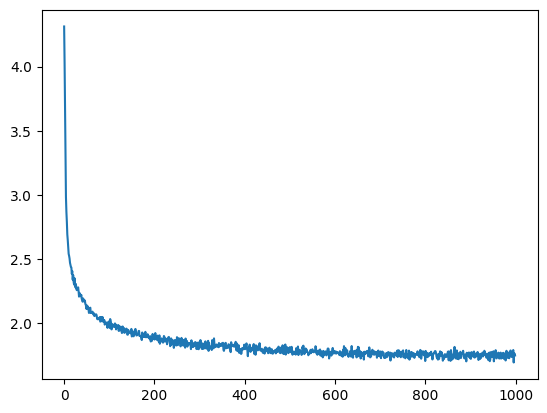

In [14]:
import matplotlib.pyplot as plt
plt.plot(all_iters_rnn, all_losses_rnn)

In [15]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        # batch = [t.to(args.device) for t in batch]
        X, Y = batch
        _, loss = model(X, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

evaluate(model, train_dataset, batch_size=128), evaluate(model, test_dataset, batch_size=128)

(1.7411311864852905, 1.7613869905471802)

In [29]:
gru_model = RNN(config, cell="gru")
batch_loader = InfiniteDataLoader(train_dataset, batch_size=128)
all_losses_gru, all_iters_gru = train_rnn(gru_model, batch_loader, epochs=1000)

step 0 | loss 4.3329
step 10 | loss 2.6192
step 20 | loss 2.4046
step 30 | loss 2.2435
step 40 | loss 2.1931
step 50 | loss 2.1261
step 60 | loss 2.0585
step 70 | loss 2.0566
step 80 | loss 1.9780
step 90 | loss 1.9748
step 100 | loss 1.9258
step 110 | loss 1.9384
step 120 | loss 1.8723
step 130 | loss 1.8301
step 140 | loss 1.8775
step 150 | loss 1.8219
step 160 | loss 1.8342
step 170 | loss 1.7974
step 180 | loss 1.8120
step 190 | loss 1.7785
step 200 | loss 1.8193
step 210 | loss 1.7613
step 220 | loss 1.7459
step 230 | loss 1.7395
step 240 | loss 1.7474
step 250 | loss 1.7238
step 260 | loss 1.7686
step 270 | loss 1.7312
step 280 | loss 1.7298
step 290 | loss 1.7221
step 300 | loss 1.7005
step 310 | loss 1.7117
step 320 | loss 1.7237
step 330 | loss 1.7396
step 340 | loss 1.6930
step 350 | loss 1.6781
step 360 | loss 1.7211
step 370 | loss 1.6920
step 380 | loss 1.6972
step 390 | loss 1.6947
step 400 | loss 1.7249
step 410 | loss 1.6867
step 420 | loss 1.6511
step 430 | loss 1.6857

In [30]:
evaluate(gru_model, train_dataset, batch_size=128), evaluate(gru_model, test_dataset, batch_size=128)

(1.6026207208633423, 1.633970856666565)

In [57]:
# print number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"number of parameters in RNN: {count_parameters(model)}")
print(f"number of parameters in GRU: {count_parameters(gru_model)}")

number of parameters in RNN: 17995
number of parameters in GRU: 34507


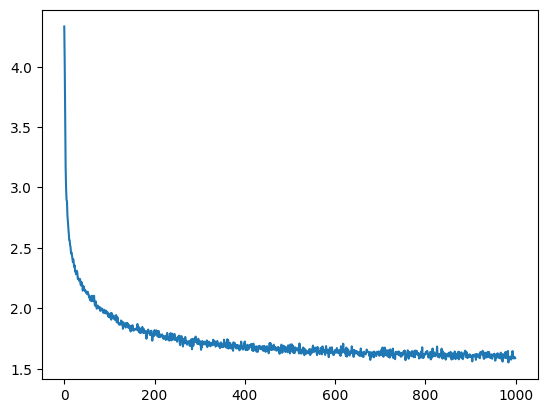

In [31]:
import matplotlib.pyplot as plt
plt.plot(all_iters_gru, all_losses_gru)

In [ ]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num, model):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = 4
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", "").replace(" .", "."))
    print('-'*80)


print_samples(num=10, model=model)


--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
thate that that in the stord i sunded to stream is shines.
with stin the preep the stands.
a sumber to lives indel young is shis the chaits all so the can.
wature.
who she clis stone to the peech i stirds is shared the such the praspleds.
when that the was but the wind tell asting are bet a stonger space and back the pares this what so long in the pere.
a takes a standing a prinds the who truck is and and shoil that ister will terrive.
in the will weat i water shatest some.
i the surresside all so me the wind i cranch the was bettance to see i warms the can thined.
whis stan.
--------------------------------------------------------------------------------


In [32]:
print_samples(num=10, model=gru_model)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
to lost in the shore.
the stonew so sea stimbered it's soul and starts falls that take a shorting.
i she still shower and touch are this who to too change and a tooms.
the way on teal winds it the first stands to let soul to like shines fall.
trught we world the such so founting is i cannant ats the falls in the friend i his.
we seen the life shines face is the strend and sunlight take trught friends that.
the wind it and the face a let suns to fill stay i chold i choose to to let.
we changes should the seas the will the too madariness to from the will stance.
in the wind the too me it's father sout than as too to chills a lights.
i fathers and and the see sun and who we stirve to life that to stars.
--------------------------------------------------------------------------------


## LSTM

In [33]:
# Inefficient implementation

class LSTMCell(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.stm = torch.zeros((config.vocab_size + 1, config.n_embd2))
        self.ltm = torch.zeros((config.vocab_size + 1, config.n_embd2))
        self.wforget = {
            "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
            "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
        }
        self.winput = {
            "pltm": {
                "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
                "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
            }, 
            "popltm": {
                "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
                "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
            }
        }
        self.woutput = {
            "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
            "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
        }
    
    def forward(self, xt):
        # forget gate
        xf = self.wforget["input"](xt)
        stmf = self.wforget["stm"](self.stm)

        # print(xf.shape, stmf.shape)

        fin = torch.sigmoid(xf + stmf)
        self.ltm *= fin

        #input gate
        xi = self.winput["pltm"]["input"](xt)
        stmi = self.winput["pltm"]["stm"](self.stm)
        io = torch.tanh(xi + stmi)

        xip = self.winput["popltm"]["input"](xt)
        stmip = self.winput["popltm"]["stm"](self.stm)
        iof = torch.sigmoid(xip + stmip)

        self.ltm += (iof * io)

        # output gate
        xo = self.woutput["input"](xt)
        stmo = self.woutput["stm"](self.stm)
        aux_out = torch.sigmoid(xo + stmo)

        fout = aux_out * (torch.tanh(self.ltm))
        self.stm = fout

        return fout
    
class LSTMCellEfficient(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.n_embd2
        self.weight = nn.Linear(config.n_embd + config.n_embd2, 4 * config.n_embd2)
        # self.dropout = nn.Dropout(p=0.2)  # Adding dropout
        # self.layer_norm = nn.LayerNorm(config.n_embd2)
        # self.dropout = nn.Dropout(p=0.2)
    def forward(self, xt, stm, ltm):
        combined = torch.cat((xt, stm), dim=-1)
        gates = self.weight(combined)
        f_gate, i_gate, o_gate, g_gate = gates.chunk(4, dim=-1)

        f_gate = torch.sigmoid(f_gate)
        i_gate = torch.sigmoid(i_gate)
        o_gate = torch.sigmoid(o_gate)
        g_gate = torch.tanh(g_gate)

        ltm = f_gate * ltm + i_gate * g_gate
        stm = o_gate * torch.tanh(ltm)

        # stm = self.layer_norm(stm)
        # stm = self.dropout(stm)

        return stm, ltm

In [40]:
def train_rnn(model, config, batch_loader, epochs=50000, steps_per_epoch=100, learning_rate=0.01, batch_size=128):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    all_losses = []
    all_iters = []

    for epoch in range(epochs):
        stm = torch.zeros(batch_size, config.n_embd2) 
        ltm = torch.zeros(batch_size, config.n_embd2)
        print(f"Epoch {epoch}")
        for step in range(steps_per_epoch): 
            batch = batch_loader.next()
            X, Y = batch

            stm, ltm, loss, _ = model(X, Y, stm, ltm)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            stm = stm.detach()
            ltm = ltm.detach()

            if step % 10 == 0:
                print(f"Step: {step}, Loss: {loss.item():.4f}")

            all_losses.append(loss.item())
            all_iters.append(epoch)

    return all_losses, all_iters

In [41]:
class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = LSTMCellEfficient(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None, ltm=None, stm=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            stm, ltm = self.cell(xt, stm, ltm)
            hiddens.append(stm)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return stm, ltm, loss, logits   


In [42]:
batch_loader = InfiniteDataLoader(train_dataset, batch_size=128)
lstm = RNN(config)
all_losses, all_iters = train_rnn(lstm, config, batch_loader, epochs=20, batch_size=128)

Epoch 0
Step: 0, Loss: 4.3255
Step: 10, Loss: 2.7485
Step: 20, Loss: 2.4386
Step: 30, Loss: 2.3060
Step: 40, Loss: 2.2316
Step: 50, Loss: 2.1798
Step: 60, Loss: 2.1339
Step: 70, Loss: 2.1133
Step: 80, Loss: 2.0836
Step: 90, Loss: 2.0573
Epoch 1
Step: 0, Loss: 2.0349
Step: 10, Loss: 2.0103
Step: 20, Loss: 1.9851
Step: 30, Loss: 1.9825
Step: 40, Loss: 1.9459
Step: 50, Loss: 1.9508
Step: 60, Loss: 1.9267
Step: 70, Loss: 1.9188
Step: 80, Loss: 1.8889
Step: 90, Loss: 1.8925
Epoch 2
Step: 0, Loss: 1.8855
Step: 10, Loss: 1.8750
Step: 20, Loss: 1.8655
Step: 30, Loss: 1.8669
Step: 40, Loss: 1.8742
Step: 50, Loss: 1.8739
Step: 60, Loss: 1.8686
Step: 70, Loss: 1.8475
Step: 80, Loss: 1.8294
Step: 90, Loss: 1.8573
Epoch 3
Step: 0, Loss: 1.8574
Step: 10, Loss: 1.8183
Step: 20, Loss: 1.7875
Step: 30, Loss: 1.8125
Step: 40, Loss: 1.8062
Step: 50, Loss: 1.8056
Step: 60, Loss: 1.8105
Step: 70, Loss: 1.8173
Step: 80, Loss: 1.8158
Step: 90, Loss: 1.8126
Epoch 4
Step: 0, Loss: 1.7816
Step: 10, Loss: 1.7662

In [56]:
# print number of params
print(f"Number of parameters: {sum(p.numel() for p in lstm.parameters())}")

Number of parameters: 42763


In [43]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        # batch = [t.to(args.device) for t in batch]
        X, Y = batch
        ltm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        stm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        stm, ltm, loss, _ = model(X, Y, stm, ltm)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

evaluate(lstm, test_dataset, batch_size=64), evaluate(lstm, train_dataset, batch_size=64)

(1.668624758720398, 1.6413921117782593)

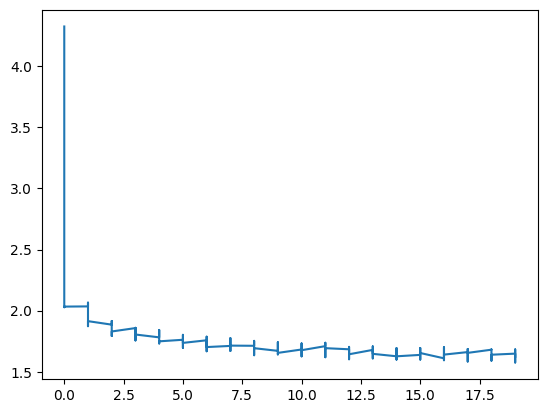

In [44]:
import matplotlib.pyplot as plt
plt.plot(all_iters, all_losses)

In [55]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        stm = torch.zeros(10, config.n_embd2)
        ltm = torch.zeros(10, config.n_embd2)
        _, _, _, logits = model(idx_cond, stm=stm, ltm=ltm)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num=10):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = 3
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(lstm, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", "").replace(" .", "."))
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
never somether the stars.
nothing and the she care a can't and a star.
walking strengs the shet this still somerigant.
all the words and the say are always are a thoughts the strenglate.
not a there's the same a still something a time the was so we leaves and such in a the persence.
with the wine an think and the walk to that's a time they child the shade.
a spring to this hollood.
when my procking and the wintered tomorrow.
wind thing so stanted an only still the staits to the stain.
will and the still and summing.
--------------------------------------------------------------------------------
